In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)

100%|██████████| 787M/787M [00:08<00:00, 93.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [ ]:
import os
os.chdir("/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1")

In [ ]:
os.listdir()

['kagglecatsanddogs_3367a']

In [ ]:
os.chdir("kagglecatsanddogs_3367a")

In [ ]:
os.listdir()

['readme[1].txt', 'MSR-LA - 3467.docx', 'PetImages']

In [ ]:
os.chdir("PetImages")

In [ ]:
os.getcwd()

'/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Parameters
DATA_DIR = "/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages"
BATCH_SIZE = 32
IMG_SIZE = 150
EPOCHS = 10
LR = 1e-4
# Data Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [ ]:
# Load Dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform = train_transform)

In [ ]:
# Train-Val Split (80%-20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [ ]:
# Change val dataset transform
val_dataset.dataset.transform = val_transform

In [ ]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # (B,32,150,150)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,32,75,75)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,64,37,37)

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,128,18,18)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128*18*18, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=41472, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
# Training and validation loop
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects = 0, 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).float().to(device)  # For BCELoss

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        running_corrects += torch.sum(preds == labels)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item())

    # Validation
    model.eval()
    val_running_loss, val_running_corrects = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_running_corrects += torch.sum(preds == labels)

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size
    val_losses.append(val_loss)
    val_accs.append(val_acc.item())

    print(f"Epoch {epoch+1}/{EPOCHS}.. "
          f"Train loss: {epoch_loss:.4f}.. Train acc: {epoch_acc:.4f}.. "
          f"Val loss: {val_loss:.4f}.. Val acc: {val_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10.. Train loss: 0.6069.. Train acc: 0.6664.. Val loss: 0.5304.. Val acc: 0.7396
Epoch 2/10.. Train loss: 0.5130.. Train acc: 0.7474.. Val loss: 0.4719.. Val acc: 0.7758
Epoch 3/10.. Train loss: 0.4651.. Train acc: 0.7810.. Val loss: 0.4633.. Val acc: 0.7736
Epoch 4/10.. Train loss: 0.4291.. Train acc: 0.8036.. Val loss: 0.4208.. Val acc: 0.8049
Epoch 5/10.. Train loss: 0.4008.. Train acc: 0.8200.. Val loss: 0.3986.. Val acc: 0.8195
Epoch 6/10.. Train loss: 0.3748.. Train acc: 0.8314.. Val loss: 0.4004.. Val acc: 0.8185
Epoch 7/10.. Train loss: 0.3520.. Train acc: 0.8473.. Val loss: 0.4005.. Val acc: 0.8103
Epoch 8/10.. Train loss: 0.3288.. Train acc: 0.8578.. Val loss: 0.3882.. Val acc: 0.8233
Epoch 9/10.. Train loss: 0.3098.. Train acc: 0.8640.. Val loss: 0.3769.. Val acc: 0.8303
Epoch 10/10.. Train loss: 0.2895.. Train acc: 0.8742.. Val loss: 0.3741.. Val acc: 0.8303


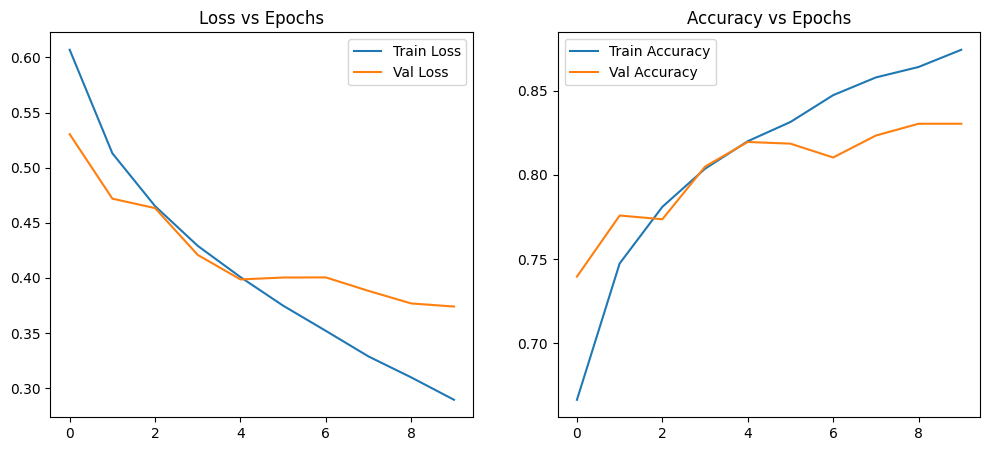

In [ ]:
# Plot loss and accuracy curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

In [ ]:
# Evaluate with sklearn metrics
all_preds = np.array(all_preds).flatten()
all_preds_binary = (all_preds > 0.5).astype(int)
all_labels = np.array(all_labels).flatten()

print("Classification Report:\n", classification_report(all_labels, all_preds_binary, target_names=full_dataset.classes))

Classification Report:
               precision    recall  f1-score   support

         Cat       0.81      0.87      0.84      2522
         Dog       0.86      0.79      0.82      2470

    accuracy                           0.83      4992
   macro avg       0.83      0.83      0.83      4992
weighted avg       0.83      0.83      0.83      4992



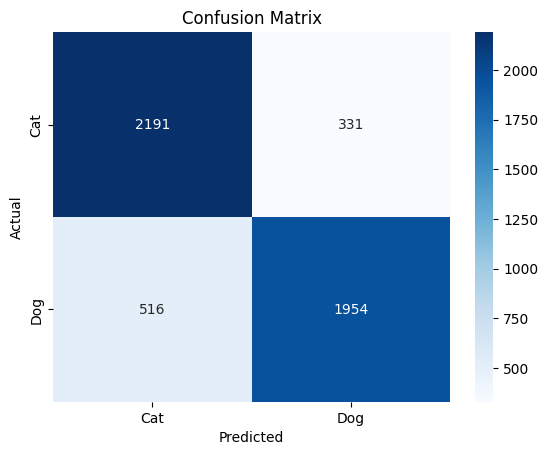

In [ ]:
# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

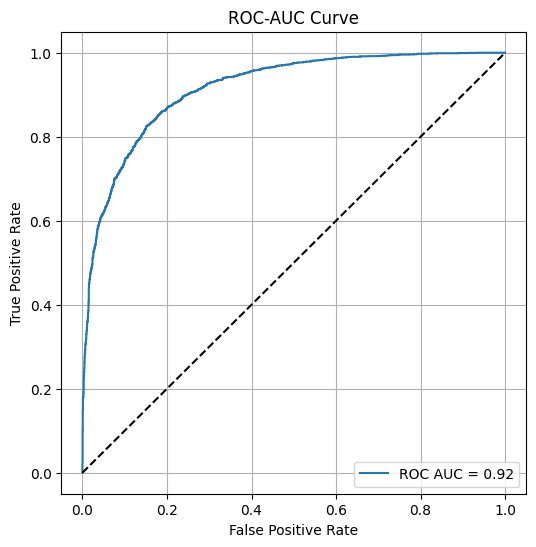

In [ ]:
# ROC-AUC Curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
'''🔹 Aim:

To design and implement a Convolutional Neural Network (CNN) model to classify images of cats and dogs using a binary classification approach.

🔹 Objectives:

Load and preprocess the dataset of cat and dog images.

Build a CNN model for binary image classification.

Train and validate the model using appropriate evaluation metrics.

Plot training history (loss vs accuracy).

Evaluate model performance using confusion matrix, classification report, and ROC-AUC curve.

🔹 Pseudocode:
1. Load and preprocess image dataset:
    - Resize images to uniform size
    - Normalize pixel values
    - Split into training and validation sets

2. Build CNN model:
    - Add Conv2D, MaxPooling2D, Dropout, and Dense layers
    - Use sigmoid activation for binary classification

3. Compile the model:
    - Use 'binary_crossentropy' as loss
    - Use 'adam' optimizer
    - Track 'accuracy' metric

4. Train the model:
    - Use training and validation data
    - Set epochs and batch size

5. Evaluate the model:
    - Plot accuracy and loss curves
    - Plot ROC-AUC curve
    - Print classification report and confusion matrix'''


"🔹 Aim:\n\nTo design and implement a Convolutional Neural Network (CNN) model to classify images of cats and dogs using a binary classification approach.\n\n🔹 Objectives:\n\nLoad and preprocess the dataset of cat and dog images.\n\nBuild a CNN model for binary image classification.\n\nTrain and validate the model using appropriate evaluation metrics.\n\nPlot training history (loss vs accuracy).\n\nEvaluate model performance using confusion matrix, classification report, and ROC-AUC curve.\n\n🔹 Pseudocode:\n1. Load and preprocess image dataset:\n    - Resize images to uniform size\n    - Normalize pixel values\n    - Split into training and validation sets\n\n2. Build CNN model:\n    - Add Conv2D, MaxPooling2D, Dropout, and Dense layers\n    - Use sigmoid activation for binary classification\n\n3. Compile the model:\n    - Use 'binary_crossentropy' as loss\n    - Use 'adam' optimizer\n    - Track 'accuracy' metric\n\n4. Train the model:\n    - Use training and validation data\n    - Set